In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from sklearn.metrics import r2_score

In [34]:
# Reading the data and putting Customer_id as index
df = pd.read_csv('/content/Mall_Customers.csv', index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [6]:
# Understanding distribution of data, looking for outliers or inconsistencies.
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [7]:
# Datatype of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [8]:
# Checking for null values
df.isnull().sum()

,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [31]:
def pie_plot():
  ''' Defining a pie plot to look at gender based distribution in the data.
  '''

  plt.figure( dpi = 144)

  plt.pie(df['Gender'].value_counts(), autopct='%1.1f%%', labels = df['Gender'].unique(), startangle = 90, explode = [0, 0.04])

  plt.title('Gender distribution', fontsize = 17)

  plt.show()

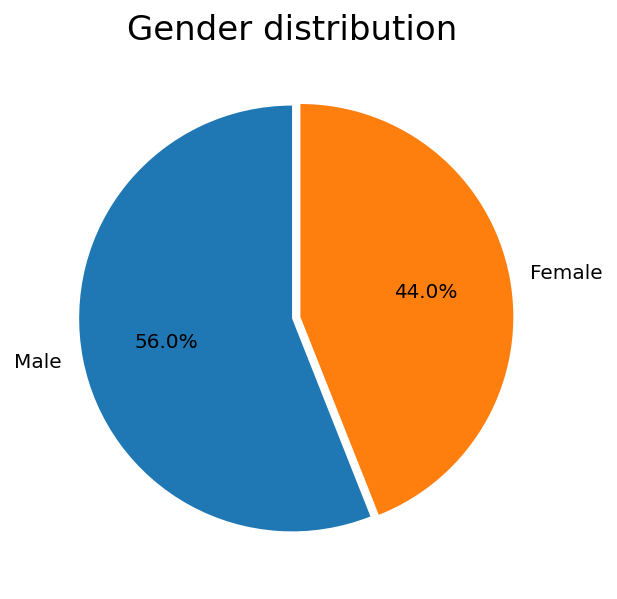

In [35]:
# Calling the pie_plot function
pie_plot()

In [11]:
# Converting categorical variable 'Gender' into Numerical one for correlation analysis.
df2 = pd.get_dummies(df)

In [12]:
df2.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
CustomerID,,,,,
1,19,15,39,False,True
2,21,15,81,False,True
3,20,16,6,True,False
4,23,16,77,True,False
5,31,17,40,True,False


In [13]:
# Changing boolean to integer values so, we can use them in heatmap
df2['Gender_Female'] = df2['Gender_Female'].astype(int)
df2['Gender_Male'] = df2['Gender_Male'].astype(int)

In [29]:
def heatmap():
 ''' Understanding correlation between variables by plotting heat map
 '''
 corr_matrix = df2.corr()

 plt.figure( dpi = 144)

 sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

 plt.title('Heatmap', fontsize = 17)
 plt.show()

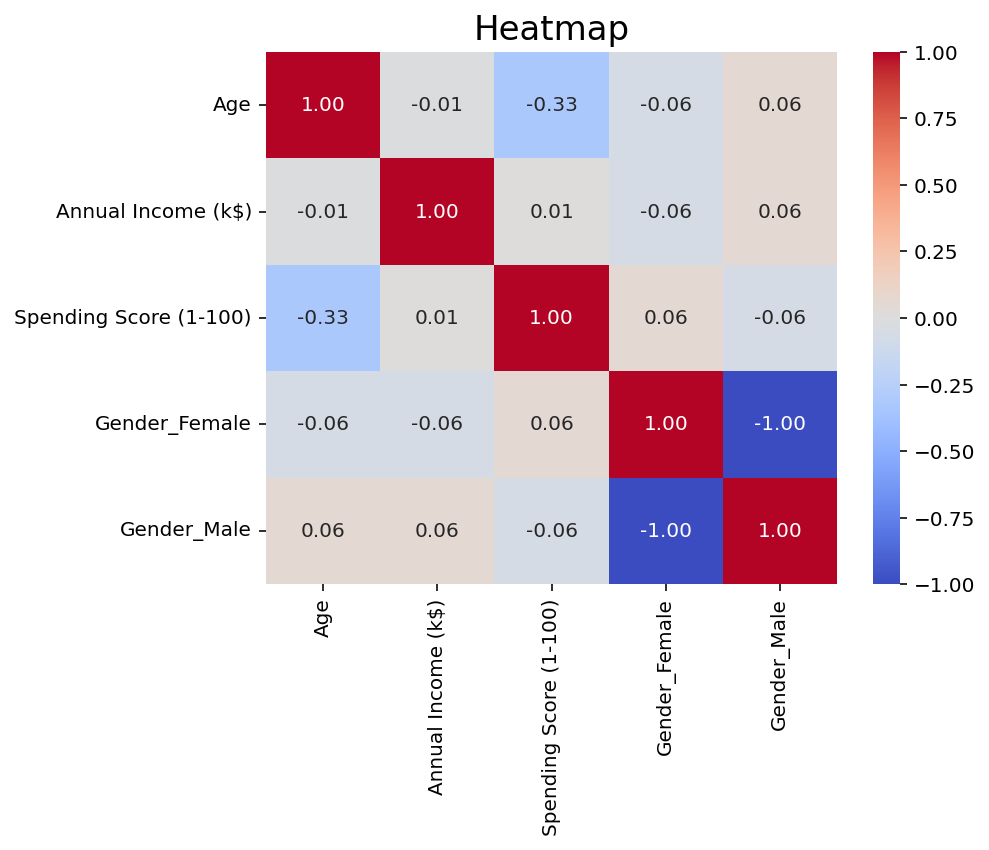

In [30]:
heatmap()

Since, Spending Score and Age show a good negative correlation, we will explore it further and find the relationship between them.

In [37]:
def spending_by_age():
  ''' Plotting a graph to visualise the relationship between spending score with respect to age.
  '''

  plt.figure(dpi = 144)

  plt.scatter(df2['Age'], df2['Spending Score (1-100)'],  c = 'Red', edgecolors = 'Black')

  plt.xlabel('Age', loc = 'center', fontsize = 17 )
  plt.ylabel('Spending Score', loc = 'center', fontsize = 17 )
  plt.title('Age Vs Spending Score', loc = 'center', fontsize = 17)

  plt.show()

  return

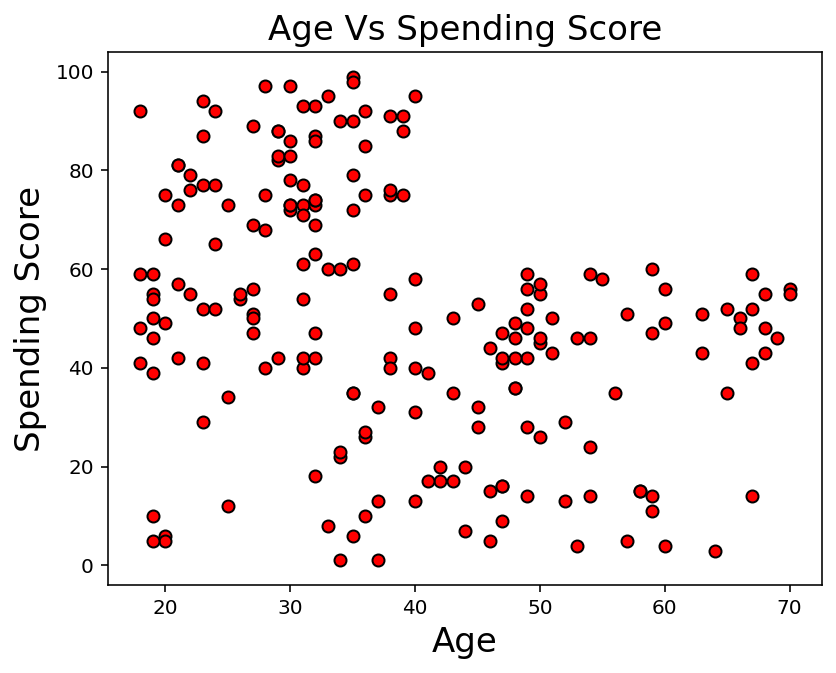

In [38]:
spending_by_age()

Since, the realtionship appears to follow an inverse exponential curve, we will fit the curve and optimize it.

In [18]:
def inverse_exp(x, a, b, c):
  ''' defining inverse exponential function to fit the points.'''
  return a * np.exp(-b*x) + c

In [19]:
# Perform the curve fitting and extraction parameters
params, covariance = curve_fit(inverse_exp,  df2['Age'], df2['Spending Score (1-100)'])
a, b, c= params
print(f"Fitted parameters: a = {a:.2f}, b = {b:.2f}, c={c:.2f}")

Fitted parameters: a = 111.61, b = 0.01, c=-34.00


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
# Generating fitted Spending Score values
Spending_fit = inverse_exp(df2['Age'], a, b, c)

In [41]:
def spending_by_age_fitted():
  ''' Plotting a graph to visualise the relationship between spending score with respect to age and fitting the exponential function in the plot.
  '''

  plt.figure(dpi = 144)

  plt.scatter( df2['Age'], df2['Spending Score (1-100)'], c = 'Red', edgecolors = 'Black')
  plt.plot(df2['Age'], Spending_fit, color='Black')

  plt.xlabel('Age', loc = 'center', fontsize = 17 )
  plt.ylabel('Spending Score', loc = 'center', fontsize = 17 )
  plt.title('Spending Score across Age', loc = 'center', fontsize = 17 )

  plt.show()

  return

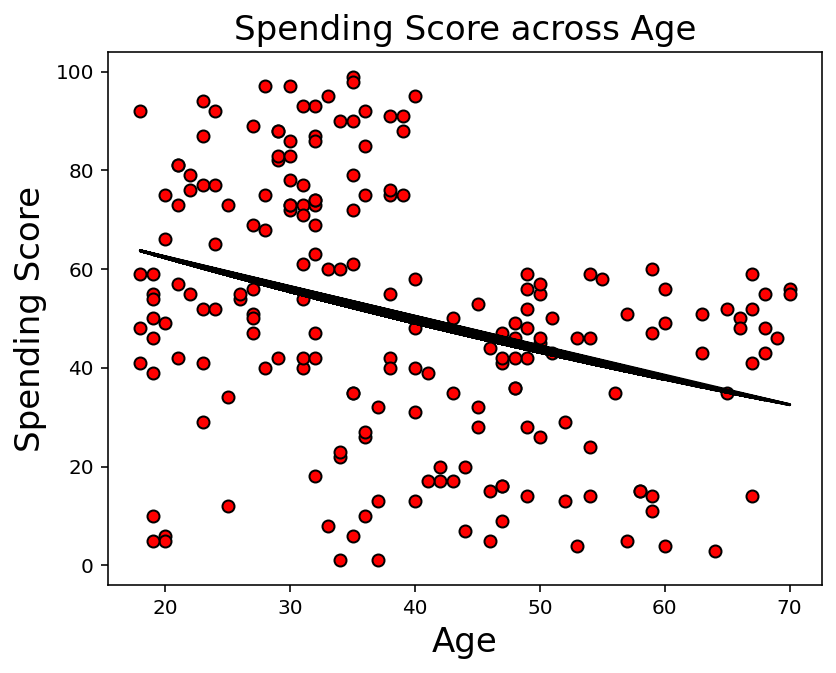

In [42]:
spending_by_age_fitted()

In [23]:
#calculating chi squared
residuals = df2['Spending Score (1-100)'] - Spending_fit
variance = np.var(df2['Spending Score (1-100)'])
chi_squared = np.sum((residuals**2) / variance)
print(f"Chi-squared: {chi_squared:.2f}")

Chi-squared: 178.45


In [24]:
# Calculate degrees of freedom
N = len(df2['Age'])
p = len(params)
df = N - p

# Calculate reduced Chi-squared
reduced_chi_squared = chi_squared / df
print(f"Reduced Chi-squared: {reduced_chi_squared:.2f}")

Reduced Chi-squared: 0.91


In [25]:
# Compute R^2 using sklearn
r2 = r2_score(df2['Spending Score (1-100)'], Spending_fit)
print(f"R-squared: {r2:.2f}")

R-squared: 0.11


The reduced Chi-squared value of 0.91 indicates that the model fits the data within the bounds of expected noise. However, the low value of R-squared of 0.11 suggests that the model explains only a small fraction of the variance in the data. It indicates that chosen model doesn't properly define the relationship, we tried it with a polynomial function as well but results were of lower standard than this.

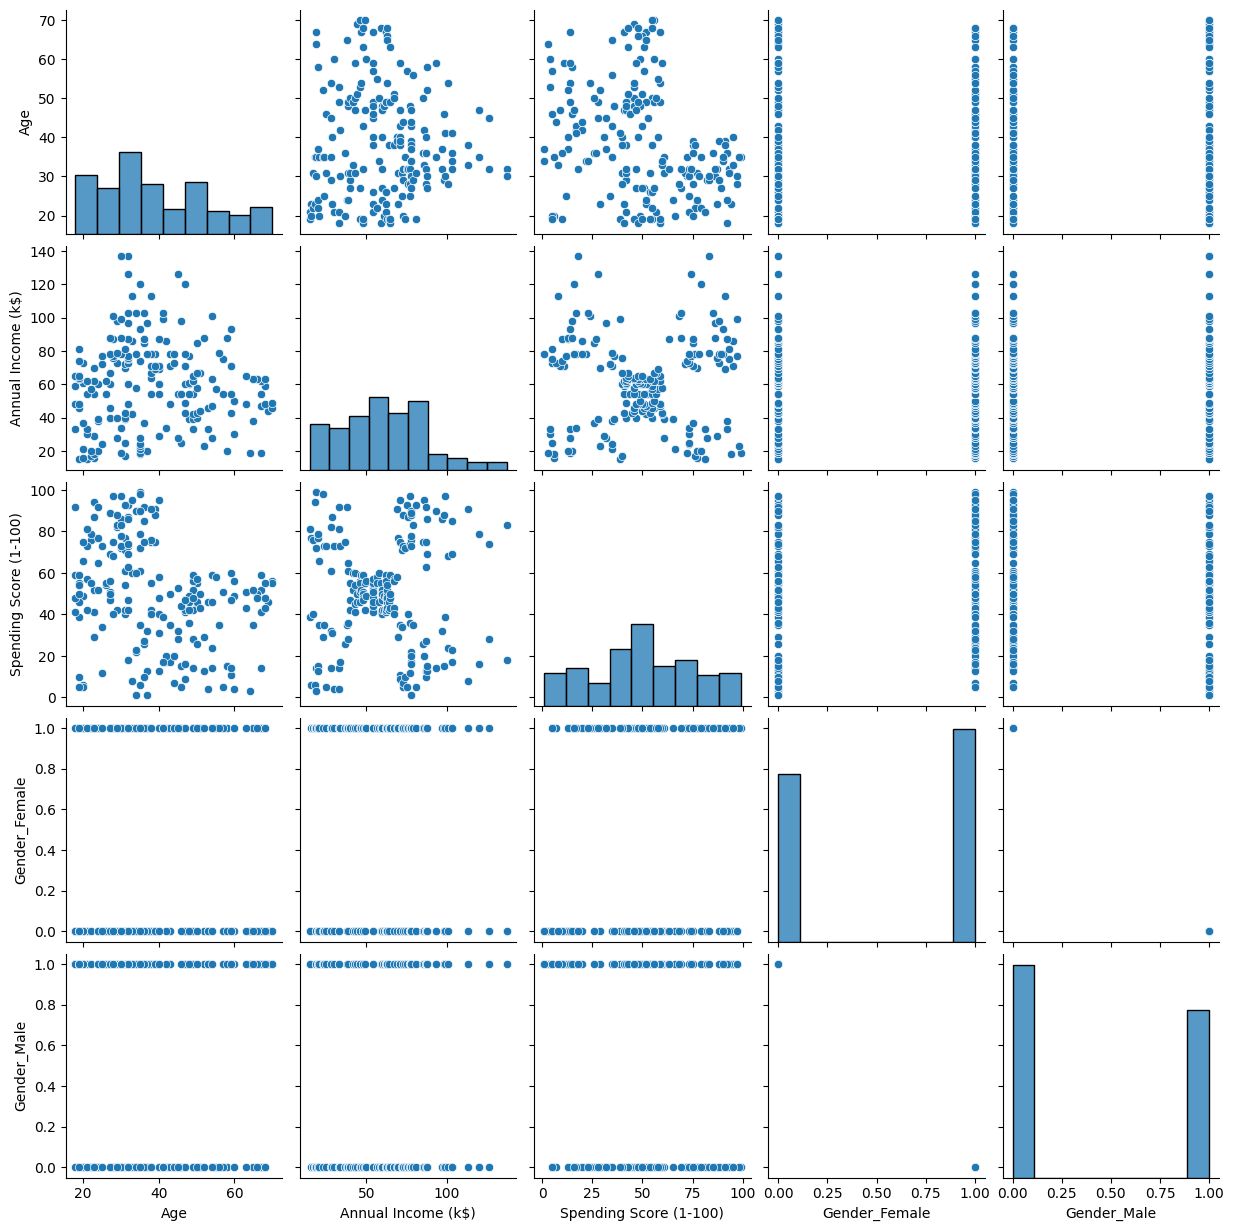

In [26]:
# Using pairplot to identify cluster between variables for analysis
sns.pairplot(df2)

We observe formation of atleast 5 clusters between the Spending score and income variables. We will explore this relationship further.

In [52]:
def gender_spending():
  ''' We are plotting to see if there is any gender based division in clusters between Spending score and Annual income.
  '''

  plt.figure(dpi = 144)

  sns.scatterplot(data = df, x = 'Annual Income (k$)', y = 'Spending Score (1-100)', hue = df['Gender'])

  plt.xlabel('Annual Income', fontsize = 17)
  plt.ylabel('Spending Score', fontsize = 17)
  plt.title('Spending Score vs Annual Income', fontsize = 17)

  plt.show()

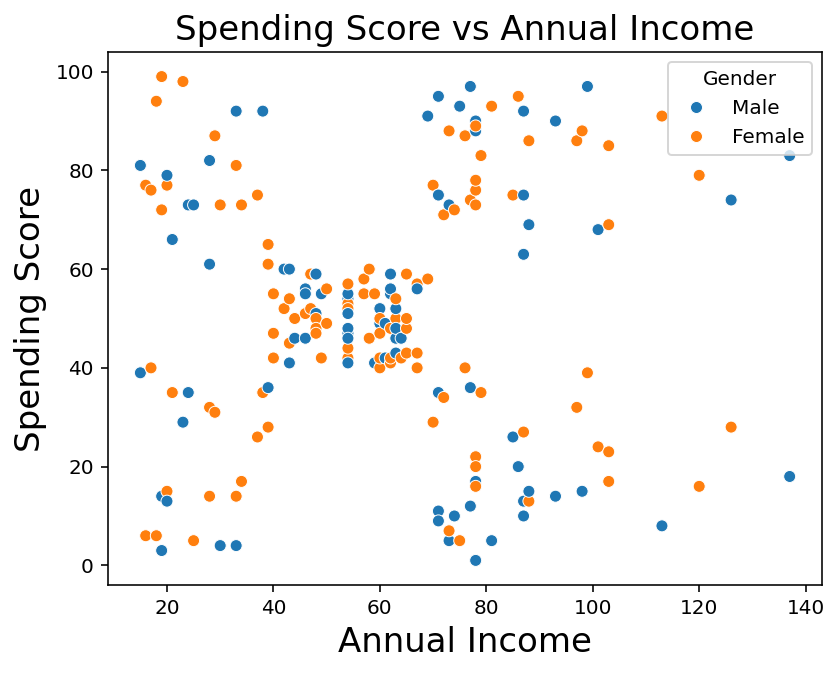

In [53]:
gender_spending()

On the basis of gender, the data appears to be uniformly distributed. So, we move forward to identifying the clusters.

In [43]:
# Defining a dataframe to make clustering easier
df3 = df[['Annual Income (k$)','Spending Score (1-100)']]

In [44]:
# Usinf K-Means clustering on the data
n_cluster = 5

kmeans = KMeans(n_clusters = n_cluster, n_init=20, random_state = 21)

kmeans.fit(df3)

labels = kmeans.labels_

# the estimated cluster centres
cen = kmeans.cluster_centers_
xkmeans = cen[:, 0]
ykmeans = cen[:, 1]

In [58]:
def plot_fitted_clusters():
    """
    Plotting the clustered data as a scatter plot with determined centres shown
    """
    fig, ax = plt.subplots(dpi=144)

    colormap = plt.cm.viridis

    s = ax.scatter(df3['Annual Income (k$)'], df3['Spending Score (1-100)'], c = labels, cmap = colormap, marker = 'o')

    cbar = fig.colorbar(s, ax=ax, ticks=range(n_cluster))
    cbar.ax.set_yticklabels([f'Cluster {i+1}' for i in range(n_cluster)])

    ax.plot(xkmeans, ykmeans, 'ko', ms=10, label='Estimated\nCenters')

    ax.set_xlabel('Annual Income (K $)', fontsize = 17)
    ax.set_ylabel('Spending Score', fontsize = 17)
    ax.set_title('Spending Score Vs Annual Income', fontsize = 17)
    ax.legend(loc = 'upper right')

    plt.show()

    return

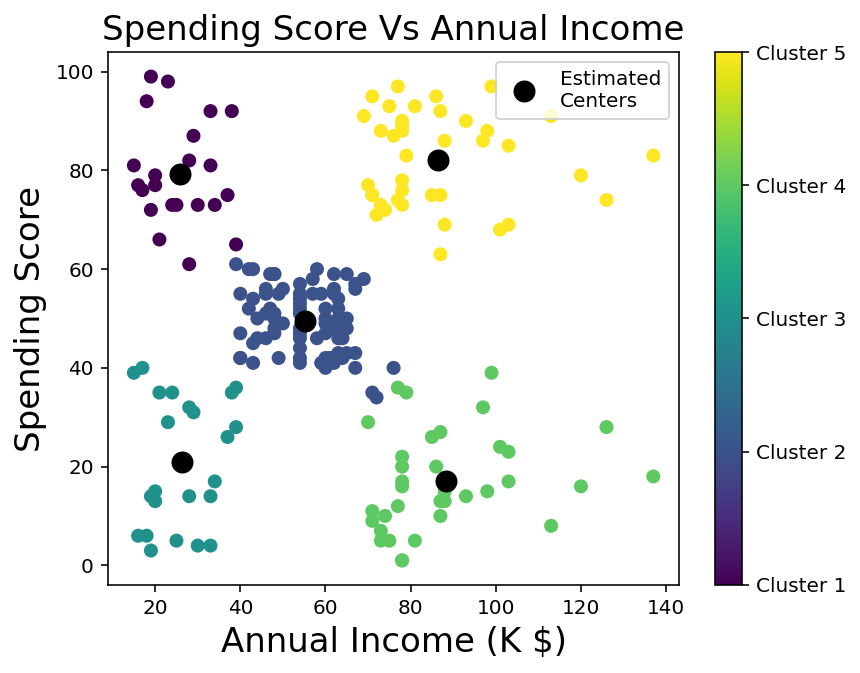

In [59]:
plot_fitted_clusters()

The clusters appear to be well defined with their centers marked. We will now plot elbow curve and determine Silhoutte score for it to decide on the optimum number of clusters for this data.

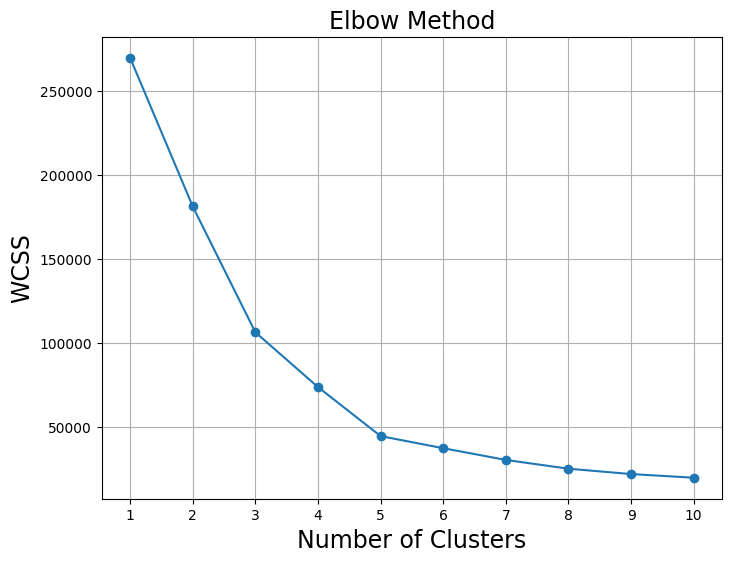

In [49]:
wcss = []
for i in range(1, 11):  # Range from 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, n_init=20, random_state = 21)
    kmeans.fit(df3)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method', fontsize = 17)
plt.xlabel('Number of Clusters', fontsize = 17)
plt.ylabel('WCSS', fontsize = 17)
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

The Elbow method suggests 4 or 5 clusters

In [50]:
# calculating Silhoutte score to determine the quality of clustering
def sil_score(n_cluster):
 ''' To calculate silhoutte score for 4 and 5 number of clusters.
 '''
 kmeans = KMeans(n_clusters = n_cluster, n_init=20, random_state = 21)
 kmeans.fit(df3)

 labels = kmeans.labels_

 sil_score = silhouette_score(df3, labels)

 return(sil_score)

In [51]:
# Calling the sil_score function.
score1 = sil_score(4)
score2 = sil_score(5)

print(score1, score2)

0.4931963109249047 0.553931997444648


The score suggests that 5 clusters is optimum for our data. Therefore, the Clustering done is optimum.